# Propensity Score Matching (PSM)
This notebook estimates propensity scores using logistic regression and perform nearest neighbor matching to calculate Conditional Average Treatment Effect (CATE) based on Propensity Score Matching (PSM) for analaysis data.

In [1]:
# import necessary libraries
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
dataset = pd.read_csv('../../data/analysis_data/dataset.csv')
data = dataset.copy()

In [3]:
# Define the treatment, covariates, and outcome
treatment_col = 'Z'
outcome_col = 'Y'
covariates = data.drop(columns=[treatment_col, outcome_col])

In [4]:
# Estimate the propensity score using logistic regression
logistic_model = LogisticRegression()
logistic_model.fit(covariates, data[treatment_col])
data['propensity_score'] = logistic_model.predict_proba(covariates)[:, 1]

c:\Users\dell\OneDrive\Desktop\Thesis\CATE_Estimation_using_Meta_Learners\venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [5]:
# Perform Propensity Score Matching (PSM) - Nearest Neighbor Matching
treated = data[data[treatment_col] == 1]
control = data[data[treatment_col] == 0]
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])
distances, indices = nn.kneighbors(treated[['propensity_score']])

In [6]:
# Match treated individuals with control individuals based on nearest neighbors
matched_control = control.iloc[indices.flatten()]

In [7]:
# Estimate CATE for PSM
cate = treated[outcome_col].reset_index(drop=True) - matched_control[outcome_col].reset_index(drop=True)
print(f"Estimated Average CATE (PSM): {cate}")

Estimated Average CATE (PSM): 0      -0.087619
1       0.332323
2       0.439673
3      -0.133548
4       0.513476
          ...   
3379    0.546582
3380    0.040908
3381   -0.295373
3382   -0.163854
3383    0.022409
Name: Y, Length: 3384, dtype: float64


In [8]:
# save cate estimates to a csv file
cate.to_csv('../../results/analysis_data_results/psm_results/cate_psm.csv', index=False)

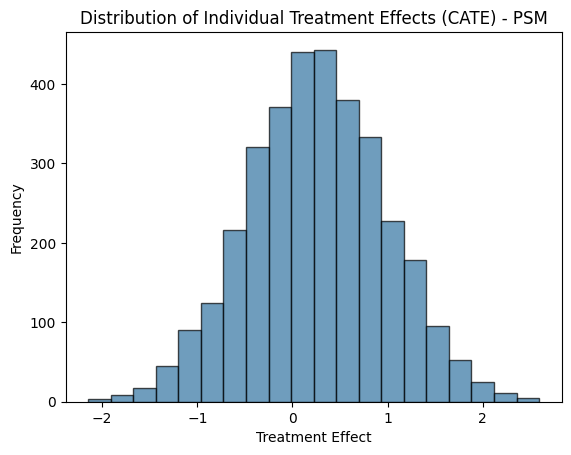

In [9]:
# Display distribution of individual CATE estimates for PSM
plt.hist(cate, bins=20, edgecolor='k', alpha=0.7, color="#3274A1")
plt.title('Distribution of Individual Treatment Effects (CATE) - PSM')
plt.xlabel('Treatment Effect')
plt.ylabel('Frequency')
plt.show()


The histogram above shows the Distribution of Individual Treatment Effects (CATE) - PSM:

* This chart shows the distribution of CATE estimates from the PSM method.
* The distribution is centered around zero with a spread across the positive and negative range.
* This suggests that PSM captures individual treatment effects, but the effects are highly variable.

# Load Meta-Learner Predictions for Comparison


In [10]:
# Load meta-learner predictions
s_predictions = pd.read_csv('../../results/analysis_data_results/test_data/s_predictions.csv')
t_predictions = pd.read_csv('../../results/analysis_data_results/test_data/t_predictions.csv')
x_predictions = pd.read_csv('../../results/analysis_data_results/test_data/x_predictions.csv')
r_predictions = pd.read_csv('../../results/analysis_data_results/test_data/r_predictions.csv')


# Visualize CATE Distributions for PSM and Meta-Learners
Compare the distributions of CATE estimates from PSM and each meta-learner to see if meta-learners provide more reliable and consistent estimates.

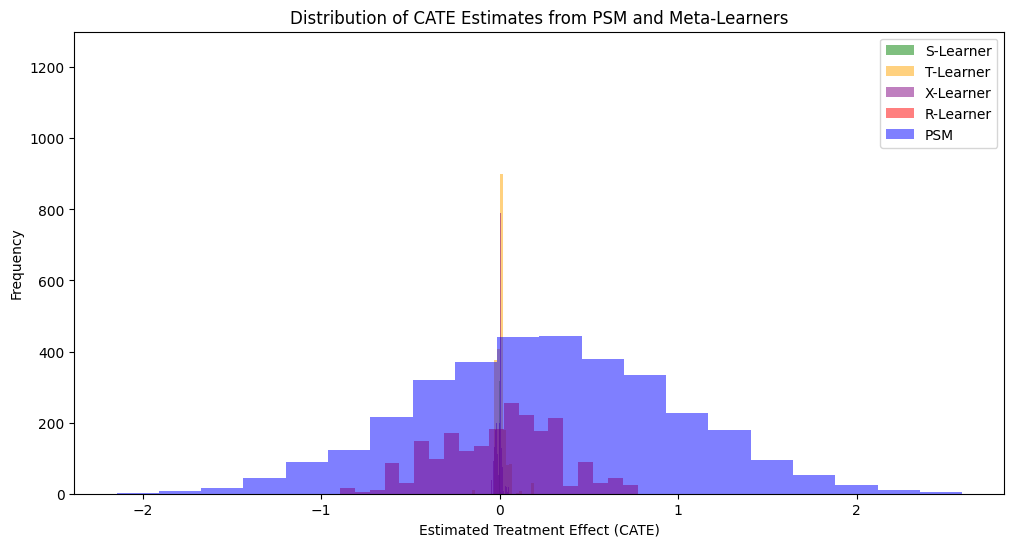

In [11]:
plt.figure(figsize=(12, 6))
plt.hist(s_predictions['s_CATE'], bins=20, alpha=0.5, label="S-Learner", color="green")
plt.hist(t_predictions['t_CATE'], bins=20, alpha=0.5, label="T-Learner", color="orange")
plt.hist(x_predictions['x_CATE'], bins=20, alpha=0.5, label="X-Learner", color="purple")
plt.hist(r_predictions['r_CATE'], bins=20, alpha=0.5, label="R-Learner", color="red")
plt.hist(cate, bins=20, alpha=0.5, label="PSM", color="blue")
plt.title("Distribution of CATE Estimates from PSM and Meta-Learners")
plt.xlabel("Estimated Treatment Effect (CATE)")
plt.ylabel("Frequency")
plt.legend()
plt.show()


Distribution of CATE Estimates from PSM and Meta-Learners:

* This plot overlays the CATE distributions from PSM and the different meta-learners.
* Meta-learner distributions (S, T, X, and R learners) appear much narrower and are concentrated around zero, whereas PSM shows a broader distribution.
* The narrow distribution in meta-learners indicates more consistency in the estimated CATE, whereas PSM suggests greater variability in treatment effects.